# Unsupervised Learning Techniques

Although  most  of  the  applications  of  Machine  Learning  today  are  based  on  supervised learning (and as a result, this is where most of the investments go to), the vast majority  of  the  available  data  is  unlabeled:  we  have  the  input  features  X,  but  we  do not have the labels y. The computer scientist Yann LeCun famously said that “if intelligence  was  a  cake,  unsupervised  learning  would  be  the  cake,  supervised  learningwould  be  the  icing  on  the  cake,  and  reinforcement  learning  would  be  the  cherry  on the  cake.”  In  other  words,  there  is  a  huge  potential  in  unsupervised  learning  that  we have only barely started to sink our teeth into.

In this chapter we will look at:

- Clustering

    The goal is to group similar instances together into clusters. Clustering is a great tool  for  data  analysis,  customer  segmentation,  recommender  systems,  search engines,  image  segmentation,  semi-supervised  learning,  dimensionality  reduction, and more.
    
    
- Anomaly detection

    The  objective  is  to  learn  what  “normal”  data  looks  like,  and  then  use  that  to detect abnormal instances, such as defective items on a production line or a new trend in a time series.
    
    
- Density estimation

    This is the task of estimating the probability density function (PDF) of the random process  that  generated  the  dataset.  Density  estimation  is  commonly  used  for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.
    
    
Ready  for  some  cake?  We  will  start  with  clustering,  using  K-Means  and  DBSCAN, and then we will discuss Gaussian mixture models and see how they can be used for density estimation, clustering, and anomaly detection.

In [1]:
import numpy as np
np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Clustering

Clustering  is  the  task  of  identifying  similar  instances  and  assigningthem to clusters, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification,  clustering  is  an  unsupervised  task.  Consider  Figure  below:  on  the  left  is  the iris  dataset,  where  each  instance’s  species  (i.e.,  its  class)  is represented  with  a  different  marker.  It  is  a  labeled  dataset,  for  which  classification algorithms  such  as  Logistic  Regression,  SVMs,  or  Random  Forest  classifiers  are  well suited.  On  the  right  is  the  same  dataset,  but  without  the  labels,  so  you  cannot  use  a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters.  That  said,  the  dataset  has  two  additional  features  (sepal  length  and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well (e.g., using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster).

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

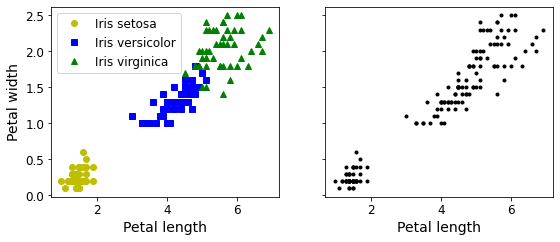

In [3]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [4]:
from sklearn.mixture import GaussianMixture

In [5]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping, we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [6]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [7]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

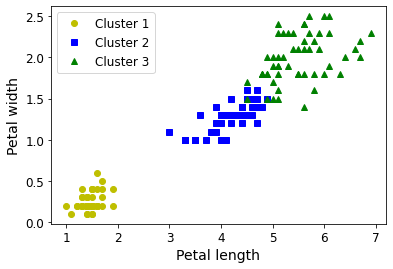

In [8]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

Let's look at the accuracy:

In [9]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

Clustering can be used in these fields:

- For customer segmentation
- For data analysis
- As a dimensionality reduction technique
- For anomaly detection (also called outlier detection)
- For semi-supervised learning
- For search engines
- To segment an image

There is no universal definition of what a cluster is: it really depends on the context, and  different  algorithms  will  capture  different  kinds  of  clusters.  Some  algorithms look  for  instances  centered  around  a  particular  point,  called  a  centroid.  Others  look for  continuous  regions  of  densely  packed  instances:  these  clusters  can  take  on  any shape. Some algorithms are hierarchical, looking for clusters of clusters. And the listgoes on.

In  this  section,  we  will  look  at  two  popular  clustering  algorithms,  K-Means  and DBSCAN,  and  explore  some  of  their  applications,  such  as  nonlinear  dimensionality reduction, semi-supervised learning, and anomaly detection.

### K-Means

Consider  the  unlabeled  dataset  represented  in  Figure  below:  you  can  clearly  see  five blobs of instances. The K-Means algorithm is a simple algorithm capable of clustering this  kind  of  dataset  very  quickly  and  efficiently,  often  in  just  a  few  iterations.  It  was proposed by Stuart Lloyd at Bell Labs in 1957 as a technique for pulse-code modulation, but it was only published outside of the company in 1982.1 In 1965, Edward W.Forgy had published virtually the same algorithm, so K-Means is sometimes referred to as Lloyd–Forgy.

In [10]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [11]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

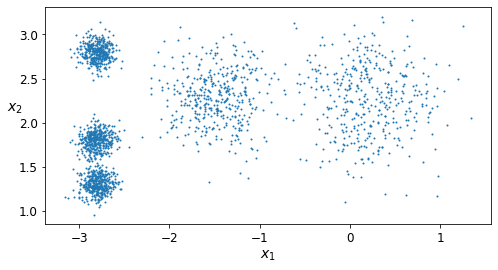

In [12]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

Let’s train a K-Means clusterer on this dataset. It will try to find each blob’s center andassign each instance to the closest blob:

In [13]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Note that you have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy. We will discuss this shortly.

Each instance was assigned to one of the five clusters. In the context of clustering, an instance’s  label  is  the  index  of  the  cluster  that  this  instance  gets  assigned  to  by  the algorithm: this is not to be confused with the class labels in classification (rememberthat  clustering  is  an  unsupervised  learning  task).  The  KMeans  instance  preserves  a copy of the labels of the instances it was trained on, available via the labels_ instance variable:

In [14]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [15]:
y_pred is kmeans.labels_

True

We can also take a look at the five centroids that the algorithm found:

In [16]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [17]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

You can easily assign new instances to the cluster whose centroid is closest:

In [18]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

#### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [2]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

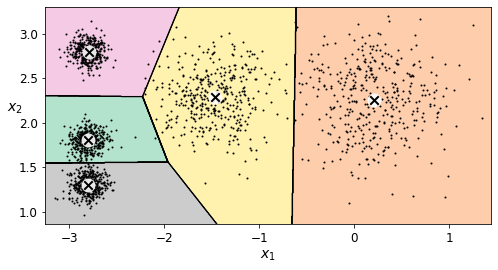

In [20]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, buta  few  instances  were  probably  mislabeled  (especially  near  the  boundary  between  the top-left  cluster  and  the  central  cluster).  Indeed,  the  K-Means  algorithm  does  not behave  very  well  when  the  blobs  have  very  different  diameters  because  all  it  caresabout when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, which is called hard clustering, it can  be  useful  to  give  each  instance  a  score  per  cluster,  which  is  called  soft  clustering. The  score  can  be  the  distance  between  the  instance  and  the  centroid;  conversely,  it can  be  a  similarity  score  (or  affinity),  such  as  the  Gaussian  Radial  Basis  Function.  In  the  KMeans  class,  the  transform()  method  measures the distance from each instance to every centroid:

In [21]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

In  this  example,  the  first  instance  in  X_new  is  located  at  a  distance  of  2.81  from  the first centroid, 0.33 from the second centroid, 2.90 from the third centroid, 1.49 fromthe fourth centroid, and 2.89 from the fifth centroid. If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: this transformation can be a very efficient nonlinear dimensionality reduction technique.

### The K-Means Algorithm

So,  how  does  the  algorithm  work?  Well,  suppose  you  were  given  the  centroids.  You could easily label all the instances in the dataset by assigning each of them to the cluster whose centroid is closest. Conversely, if you were given all the instance labels, you could easily locate all the centroids by computing the mean of the instances for each cluster.  But  you  are  given  neither  the  labels  nor  the  centroids,  so  how  can  you  proceed? Well, just start by placing the centroids randomly (e.g., by picking k instances at random  and  using  their  locations  as  centroids).  Then  label  the  instances,  update  the centroids, label the instances, update the centroids, and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps (usually quite small); it will not oscillate forever, that’s because the mean squared distance between the instances and their closest centroid can only go down at each step.

You  can  see  the  algorithm  in  action  in  Figure  below:  the  centroids  are  initialized  randomly  (top  left),  then  the  instances  are  labeled  (top  right),  then  the  centroids  are updated (center left), the instances are relabeled (center right), and so on. As you can see, in just three iterations, the algorithm has reached a clustering that seems close to optimal.

The  computational  complexity  of  the  algorithm  is  generally  linear with regard to the number of instances m, the number of clusters k, and  the  number  of  dimensions  n.  However,  this  is  only  true  when the data has a clustering structure. If it does not, then in the worstcase  scenario  the  complexity  can  increase  exponentially  with  the number of instances. In practice, this rarely happens, and K-Means is generally one of the fastest clustering algorithms.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [22]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

Let's plot the image:

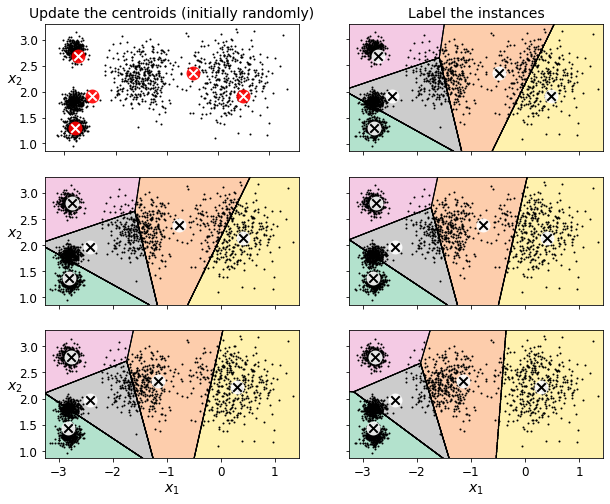

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

Although  the  algorithm  is  guaranteed  to  converge,  it  may  not  converge  to  the  right solution (i.e., it may converge to a local optimum): whether it does or not depends on the  centroid  initialization.  Figure  below  shows  two  suboptimal  solutions  that  the  algorithm can converge to if you are not lucky with the random initialization step.

In [24]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

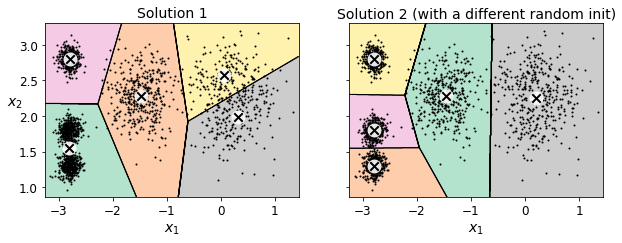

In [25]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

#### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [26]:
kmeans.inertia_

211.59853725816836

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:

In [27]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581683

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_greater is better_" rule.

In [28]:
kmeans.score(X)

-211.59853725816836

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [29]:
kmeans_rnd_init1.inertia_

219.43539442771407

In [30]:
kmeans_rnd_init2.inertia_

211.5985372581684

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [31]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

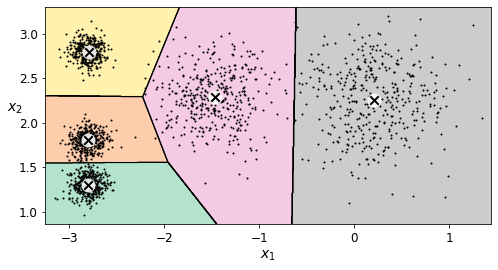

In [32]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Centroid initializaton methods

If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [33]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.59853725816836

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

### Accelerated K-Means and mini-batch K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

Yet  another  important  variant  of  the  K-Means  algorithm  was  proposed  in  a  [2010 paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)  by  David  Sculley.  Instead  of  using  the  full  dataset  at  each  iteration,  the  algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of three or four and makes itpossible  to  cluster  huge  datasets  that  do  not  fit  in  memory.  Scikit-Learn  implements this  algorithm  in  the  MiniBatchKMeans  class.  You  can  just  use  this  class  like  the KMeans class:

In [34]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)
minibatch_kmeans.inertia_

211.65239850433204

If the dataset does not fit in memory, the simplest option is to use the memmap class, as we did for incremental PCA. Alternatively, you can pass one mini-batch at a time to the partial_fit() method, but this will require much more work, since you will need to perform multiple initializations and select the best one yourself.

Let's use MNIST dataset for memmap demonestration.

In [35]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a `memmap`:

In [37]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [38]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [39]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [40]:
np.random.seed(42)

k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [41]:
best_kmeans.score(X)

-211.62571878891143

Mini-batch K-Means is much faster than regular K-Means:

In [42]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

62.7 ms ± 7.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

37.2 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Although  the  Mini-batch  K-Means  algorithm  is  much  faster  than  the  regular  K-Means  algorithm,  its  inertia  is  generally  slightly  worse,  especially  as  the  number  of clusters  increases.  You  can  see  this  in  Figure  below:  the  plot  on  the  left  compares  the inertias of Mini-batch K-Means and regular K-Means models trained on the previous dataset  using  various  numbers  of  clusters  k.  The  difference  between  the  two  curves remains  fairly  constant,  but  this  difference  becomes  more  and  more  significant  as  k increases, since the inertia becomes smaller and smaller. In the plot on the right, youcan see that Mini-batch K-Means is much faster than regular K-Means, and this difference increases with k.

In [44]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

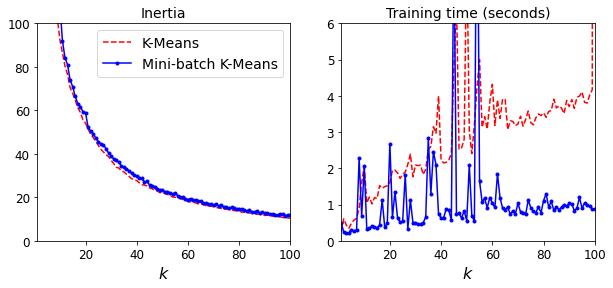

In [45]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

### Finding the optimal number of clusters

So far, we have set the number of clusters k to 5 because it was obvious by looking at the data that this was the correct number of clusters. But in general, it will not be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value. As you can see in Figure below, setting k to 3 or 8 results in fairly bad models.

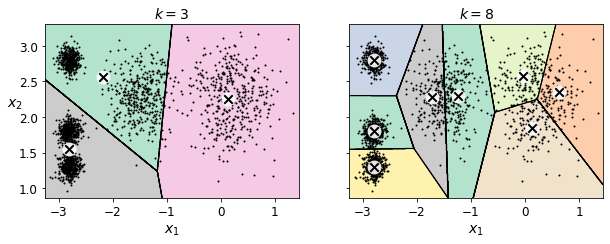

In [46]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [47]:
kmeans_k3.inertia_

653.2167190021554

In [48]:
kmeans_k8.inertia_

119.11983416102879

You  might  be  thinking  that  we  could  just  pick  the  model  with  the  lowest  inertia, right? Unfortunately, it is not that simple. The inertia for k=3 is 653.2, which is muchhigher  than  for  k=5  (which  was  211.6).  But  with  k=8,  the  inertia  is  just  119.1.  The inertia  is  not  a  good  performance  metric  when  trying  to  choose  k  because  it  keeps getting  lower  as  we  increase  k.  Indeed,  the  more  clusters  there  are,  the  closer  each instance will be to its closest centroid, and therefore the lower the inertia will be. Let’s plot the inertia as a function of k.

In [49]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

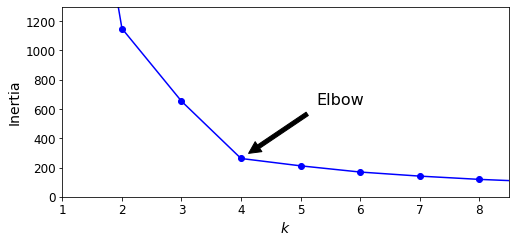

In [50]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

plt.show()

As  you  can  see,  the  inertia  drops  very  quickly  as  we  increase  k  up  to  4,  but  then  it decreases  much  more  slowly  as  we  keep  increasing  k.  This  curve  has  roughly  the shape  of  an  arm,  and  there  is  an  “elbow”  at  k  =  4.  So,  if  we  did  not  know  better,  4 would  be  a  good  choice:  any  lower  value  would  be  dramatic,  while  any  higher  value would not help much, and we might just be splitting perfectly good clusters in half for no good reason.

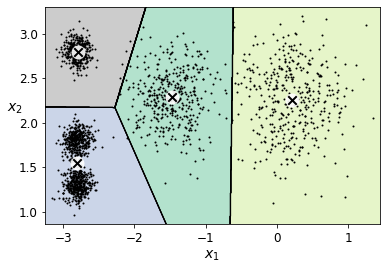

In [51]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

This technique for choosing the best value for the number of clusters is rather coarse. A  more  precise  approach  (but  also  more  computationally  expensive)  is  to  use  the **silhouette  score**,  which  is  the  mean  **silhouette  coefficient**   over  all  the  instances.  An instance’s  silhouette  coefficient  is  equal  to  (b  –  a)  /  max(a,  b),  where  a  is  the  mean distance  to  the  other  instances  in  the  same  cluster  (i.e.,  the  mean  intra-cluster  distance)  and  b  is  the  mean  nearest-cluster  distance  (i.e.,  the  mean  distance  to  the instances  of  the  next  closest  cluster,  defined  as  the  one  that  minimizes  b,  excluding the instance’s own cluster). The silhouette coefficient can vary between –1 and +1. A coefficient  close  to  +1  means  that  the  instance  is  well  inside  its  own  cluster  and  far from  other  clusters,  while  a  coefficient  close  to  0  means  that  it  is  close  to  a  cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

To  compute  the  silhouette  score,  you  can  use  Scikit-Learn’s  silhouette_score() function, giving it all the instances in the dataset and the labels they were assigned:

In [52]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

In [53]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

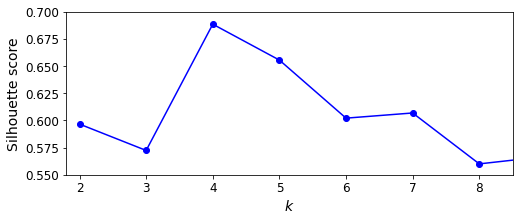

In [54]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

plt.show()

As  you  can  see,  this  visualization  is  much  richer  than  the  previous  one:  although  itconfirms that k = 4 is a very good choice, it also underlines the fact that k = 5 is quitegood as well, and much better than k = 6 or 7. This was not visible when comparing inertias.

An  even  more  informative  visualization  is  obtained  when  you  plot  every  instance’s silhouette coefficient, sorted by the cluster they are assigned to and by the value of thecoefficient.  This  is  called  a  silhouette  diagram  (figure below).  Each  diagram  contains one knife shape per cluster. The shape’s height indicates the number of instances the  cluster  contains,  and  its  width  represents  the  sorted  silhouette  coefficients  of  theinstances  in  the  cluster  (wider  is  better).  The  dashed  line  indicates  the  mean  silhouette coefficient.

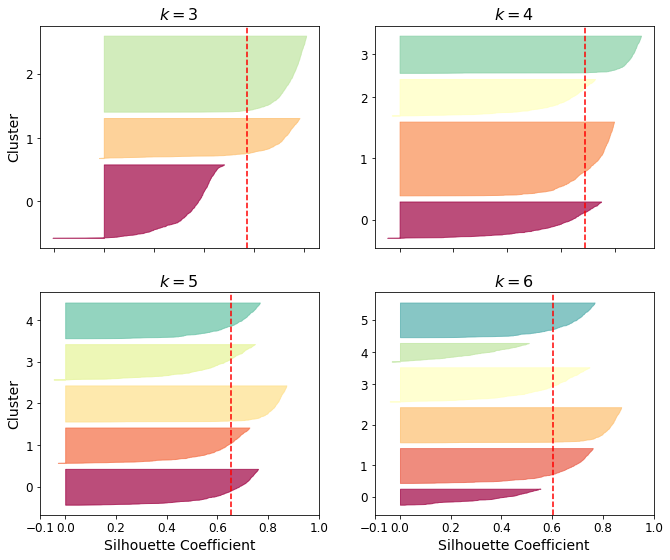

In [55]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

The  vertical  dashed  lines  represent  the  silhouette  score  for  each  number  of  clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster  is  rather  bad  since  this  means  its  instances  are  much  too  close  to  other  clusters. We can see that when k = 3 and when k = 6, we get bad clusters. But when k = 4 or k = 5, the clusters look pretty good: most instances extend beyond the dashed line,to  the  right  and  closer  to  1.0.  When  k  =  4,  the  cluster  at  index  1  (the  third  from  the top)  is  rather  big.  When  k  =  5,  all  clusters  have  similar  sizes.  So,  even  though  the overall  silhouette  score  from  k  =  4  is  slightly  greater  than  for  k  =  5,  it  seems  like  a good idea to use k = 5 to get clusters of similar sizes.

## Limits of K-Means

Despite its many merits, most notably being fast and scalable, K-Means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid suboptimal solutions,  plus  you  need  to  specify  the  number  of  clusters,  which  can  be  quite  a  hassle. Moreover,  K-Means  does  not  behave  very  well  when  the  clusters  have  varying  sizes, different  densities,  or  non spherical  shapes.  For  example,  Figure  below  shows  how  K-Means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities, and orientations.

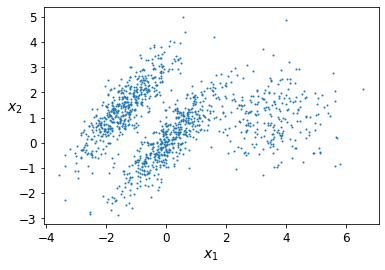

In [56]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_clusters(X)

In [57]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

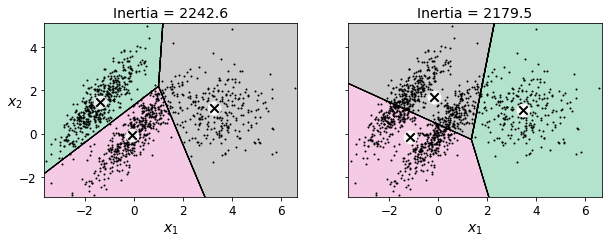

In [58]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

As you can see, neither of these solutions is any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right.  The  solution  on  the  right  is  just  terrible,  even  though  its  inertia  is  lower.  So, depending on the data, different clustering algorithms may perform better. On these types of elliptical clusters, Gaussian mixture models work great.

It  is important to scale the input features before you run K-Means, or  the  clusters  may  be  very  stretched  and  K-Means  will  performpoorly.  Scaling  the  features  does  not  guarantee  that  all  the  clusters will be nice and spherical, but it generally improves things.

## Using Clustering for Image Segmentation

Image  segmentation  is  the  task  of  partitioning  an  image  into  multiple  segments.  In semantic segmentation, all pixels that are part of the same object type get assigned to the same segment. For example, in a self-driving car’s vision system, all pixels that are part  of  a  pedestrian’s  image  might  be  assigned  to  the  “pedestrian”  segment  (there would  be  one  segment  containing  all  the  pedestrians).  In  instance  segmentation,  all pixels that are part of the same individual object are assigned to the same segment. In this  case  there  would  be  a  different  segment  for  each  pedestrian.  The  state  of  the  art in  semantic  or  instance  segmentation  today  is  achieved  using  complex  architectures based  on  convolutional  neural  networks.  Here,  we  are  going  to  do something much simpler: color segmentation. We will simply assign pixels to the same segment if they have a similar color. In some applications, this may be sufficient. For example,  if  you  want  to  analyze  satellite  images  to  measure  how  much  total  forest area there is in a region, color segmentation may be just fine.

In [59]:
# Download the ladybug image
import os

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7f6af401da90>)

In [60]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

The  image  is  represented  as  a  3D  array.  The  first  dimension’s  size  is  the  height;  the second  is  the  width;  and  the  third  is  the  number  of  color  channels,  in  this  case  red, green, and blue (RGB). In other words, for each pixel there is a 3D vector containing the  intensities  of  red,  green,  and  blue,  each  between  0.0  and  1.0  (or  between  0  and 255,  if  you  use  imageio.imread()).  Some  images  may  have  fewer  channels,  such  as grayscale images (one channel). And some images may have more channels, such as images  with  an  additional  alpha  channel  for  transparency  or  satellite  images,  which often contain channels for many light frequencies (e.g., infrared). The following code reshapes the array to get a long list of RGB colors, then it clusters these colors using K-Means:

In [62]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

For  example,  it  may  identify  a  color  cluster  for  all  shades  of  green.  Next,  for  each color  (e.g.,  dark  green),  it  looks  for  the  mean  color  of  the  pixel’s  color  cluster.  For example, all shades of green may be replaced with the same light green color (assuming the mean color of the green cluster is light green). Finally, it reshapes this long list of colors to get the same shape as the original image. And we’re done!

This outputs the image shown in the upper right of Figure below. You can experiment with  various  numbers  of  clusters,  as  shown  in  the  figure.  When  you  use  fewer  than eight clusters, notice that the ladybug’s flashy red color fails to get a cluster of its own: it  gets  merged  with  colors  from  the  environment.  This  is  because  K-Means  prefers clusters  of  similar  sizes.  The  ladybug  is  small much  smaller  than  the  rest  of  theimage so even though its color is flashy, K-Means fails to dedicate a cluster to it.

In [63]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

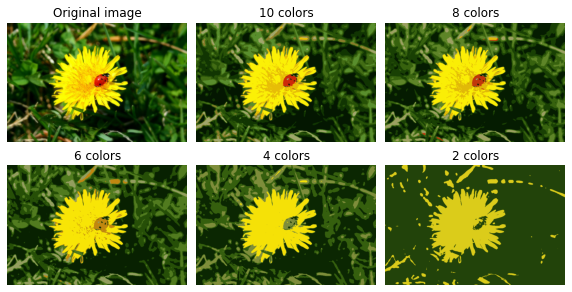

In [65]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

## Using Clustering for Preprocessing

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing  step  before  a  supervised  learning  algorithm.  As  an  example  of  using clustering for dimensionality reduction, let’s tackle the digits dataset, which is a simple MNIST-like dataset containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9. First, load the dataset:

In [66]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

Split Train and Test sets:

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [70]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

Let's evaluate the accuracy on the test set:

In [72]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters ( Since there are 10 different digits, it is tempting to set the number of clusters to 10. However, each digit can be written several different ways, so it is preferable to use a larger number of clusters, such as 50), then apply a logistic regression model:

In [75]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

Error rate drop:

In [76]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

How about that? We reduced the error rate by over 28%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance. We  can  use  GridSearchCV  to  find  the optimal number of clusters:

In [77]:
# This will take too long to run (about 30 min) depending on your pc performance

from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   1.5s
[CV] END ...............................kmeans__n_clusters=2; total time=   1.3s
[CV] END ...............................kmeans__n_clusters=2; total time=   1.5s
[CV] END ...............................kmeans__n_clusters=3; total time=   1.4s
[CV] END ...............................kmeans__n_clusters=3; total time=   1.5s
[CV] END ...............................kmeans__n_clusters=3; total time=   1.4s
[CV] END ...............................kmeans__n_clusters=4; total time=   1.5s
[CV] END ...............................kmeans__n_clusters=4; total time=   1.4s
[CV] END ...............................kmeans__n_clusters=4; total time=   1.4s
[CV] END ...............................kmeans__n_clusters=5; total time=   1.6s
[CV] END ...............................kmeans__n_clusters=5; total time=   1.5s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=  10.2s
[CV] END ..............................kmeans__n_clusters=36; total time=  11.9s
[CV] END ..............................kmeans__n_clusters=36; total time=  11.6s
[CV] END ..............................kmeans__n_clusters=36; total time=  11.2s
[CV] END ..............................kmeans__n_clusters=37; total time=  11.4s
[CV] END ..............................kmeans__n_clusters=37; total time=  10.7s
[CV] END ..............................kmeans__n_clusters=37; total time=   9.3s
[CV] END ..............................kmeans__n_clusters=38; total time=  11.9s
[CV] END ..............................kmeans__n_clusters=38; total time=  12.2s
[CV] END ..............................kmeans__n_clusters=38; total time=  11.9s
[CV] END ..............................kmeans__n_clusters=39; total time=  11.4s
[CV] END ..............................kmeans__n_clusters=39; total time=  12.2s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   7.5s
[CV] END ..............................kmeans__n_clusters=70; total time=  13.5s
[CV] END ..............................kmeans__n_clusters=70; total time=  12.7s
[CV] END ..............................kmeans__n_clusters=70; total time=  12.5s
[CV] END ..............................kmeans__n_clusters=71; total time=  12.8s
[CV] END ..............................kmeans__n_clusters=71; total time=  12.1s
[CV] END ..............................kmeans__n_clusters=71; total time=  13.4s
[CV] END ..............................kmeans__n_clusters=72; total time=  12.7s
[CV] END ..............................kmeans__n_clusters=72; total time=  12.2s
[CV] END ..............................kmeans__n_clusters=72; total time=  12.2s
[CV] END ..............................kmeans__n_clusters=73; total time=  14.5s
[CV] END ..............................kmeans__n_clusters=73; total time=  12.6s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

Let’s look at the best value for k and the performance of the resulting pipeline:

In [81]:
grid_clf.best_params_

{'kmeans__n_clusters': 95}

In [83]:
grid_clf.score(X_test, y_test)

0.9777777777777777

With K=95 Clusters we will get significant accuracy boost.

## Using Clustering for  Semi-Supervised Learning

Another  use  case  for  clustering  is  in  semi-supervised  learning,  when  we  have  plenty of unlabeled instances and very few labeled instances. Let’s train a Logistic Regression model on a sample of 50 labeled instances from the digits dataset:

In [105]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

The accuracy is just 83.3%. It should come as no surprise that this is much lower than earlier,  when  we  trained  the  model  on  the  full  training  set.  Let’s  see  how  we  can  do better.  First,  let’s  cluster  the  training  set  into  50  clusters.  Then  for  each  cluster,  let’s find  the  image  closest  to  the  centroid.  We  will  call  these  images  the  representative images:

In [106]:
k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

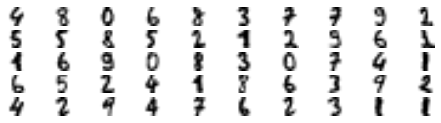

In [107]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [108]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

Let’s look at each image and manually label it:

In [113]:
y_representative_digits = np.array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 
                                    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
                                    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
                                    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
                                    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Now  we  have  a  dataset  with  just  50  labeled  instances,  but  instead  of  being  random instances, each of them is a representative image of its cluster. Let’s see if the performance is any better:

In [114]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

Wow! We jumped from 83.3% accuracy to 92.2%, although we are still only training the model on 50 instances. Since it is often costly and painful to label instances, especially when it has to be done manually by experts, it is a good idea to label representative instances rather than just random instances.

But  perhaps  we  can  go  one  step  further:  what  if  we  propagated  the  labels  to  all  the other instances in the same cluster? This is called label propagation:

In [115]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [124]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [118]:
log_reg.score(X_test, y_test)

0.9333333333333333

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 75th percentile closest to the centroid:

In [ ]:
We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 75th percentile closest to the centroid:

In [119]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [120]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [121]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [122]:
log_reg.score(X_test, y_test)

0.9355555555555556

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 93.5% performance, which is getting closer to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%). This is because the propagated labels are actually pretty good: their accuracy is close to 98%:

In [123]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9750747756729811

### Active Learning

To continue improving your model and your training set, the next step could be to do a  few  rounds  of  active  learning,  which  is  when  a  human  expert  interacts  with  the learning   algorithm,   providing   labels   for   specific   instances   when   the   algorithm requests them. There are many different strategies for active learning, but one of the most common ones is called uncertainty sampling. Here is how it works:

1. The  model  is  trained  on  the  labeled  instances  gathered  so  far,  and  this  model  is used to make predictions on all the unlabeled instances.

1. The  instances  for  which  the  model  is  most  uncertain  (i.e.,  when  its  estimated probability is lowest) are given to the expert to be labeled.

1. You  iterate  this  process  until  the  performance  improvement  stops  being  worth the labeling effort.

Other  strategies  include  labeling  the  instances  that  would  result  in  the  largest  model change, or the largest drop in the model’s validation error, or the instances that different models disagree on (e.g., an SVM or a Random Forest).

## DBSCAN

This algorithm defines clusters as continuous regions of high density. Here is how it works:

- For each instance, the algorithm counts how many instances are located within a small   distance   ε   (epsilon)   from   it.   This   region   is   called   the   instance’s   ε-neighborhood.

- If  an  instance  has  at  least  min_samples  instances  in  its  ε-neighborhood  (including itself ), then it is considered a core instance. In other words, core instances are those that are located in dense regions.

- All  instances  in  the  neighborhood  of  a  core  instance  belong  to  the  same  cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.

- Any  instance  that  is  not  a  core  instance  and  does  not  have  one  in  its  neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough and if they are well separated by low-density regions. The DBSCAN class in Scikit-Learn is as simple to use as you might expect. Let’s test it on the moons dataset.

In [174]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

Labels of all the instances are now available in the labels_:

In [175]:
dbscan.labels_

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4,  0,  5,  1,  0,  5,  5,  3,  2,  2,  2,  4,  5,  0,  6,
        1, -1,  0,  0,  2,  3, -1,  3,  4, -1,  4,  4,  2,  0,  6,  2,  0,
        2,  4,  0,  3,  3,  0,  3,  5,  2, -1,  3,  0,  5,  0,  0,  0,  2,
        3,  0,  3,  6,  0,  2,  4,  4,  0,  3,  0,  4,  0,  3, -1,  3,  4,
        0, -1,  2,  2,  4,  1,  6,  0,  5,  2,  6,  2,  3,  3, -1,  2, -1,
        2,  4,  0,  0,  0,  2,  5,  2,  0,  2, -1,  2,  3,  1,  5,  2,  0,
        4,  2,  1,  2,  4,  4,  0,  0,  6,  2,  2,  0,  2, -1,  2,  0,  3,
        3,  5, -1,  3,  3,  5,  2,  4,  2,  2,  2,  4,  2,  4,  0, -1,  2,
        1,  2,  6,  4,  2,  3,  2, -1,  2,  0,  0,  2,  0,  4,  0,  4,  4,
        1,  6,  3,  2,  6,  1,  4,  4,  2,  0,  6,  0,  1,  0,  2,  5,  1,
        1,  2,  2,  2,  2,  0,  5,  5,  1,  4,  5,  0,  3,  3,  0,  0,  0,
        2,  0,  5,  2, -1,  2,  3,  5,  2,  2,  0,  4,  0,  4,  2,  2,  4,
        2,  2,  3,  2,  3

Notice  that  some  instances  have  a  cluster  index  equal  to  –1,  which  means  that  they are  considered  as  anomalies  by  the  algorithm.  The  indices  of  the  core  instances  are available  in  the  core_sample_indices_  instance  variable,  and  the  core  instances themselves are available in the components_ instance variable:

In [176]:
len(dbscan.core_sample_indices_)

808

In [177]:
dbscan.core_sample_indices_

array([  0,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  36,  38,  39,  41,  42,  44,  45,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  61,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  83,  84,  85,  87,  88,  89,  90,  91,  93,  94,  96,
        97,  98, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114,
       115, 116, 117, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 135, 136, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149,
       150, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178,
       179, 181, 182, 183, 185, 186, 187, 188, 189, 191, 193, 194, 195,
       196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 22

In [178]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

This  clustering  is  represented  in  the  lefthand  plot  of  Figure  below.  As  you  can  see,  it identified  quite  a  lot  of  anomalies,  plus  seven  different  clusters.  How  disappointing! Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get the clustering on the right, which looks perfect. Let’s continue with this model.

In [179]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [180]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

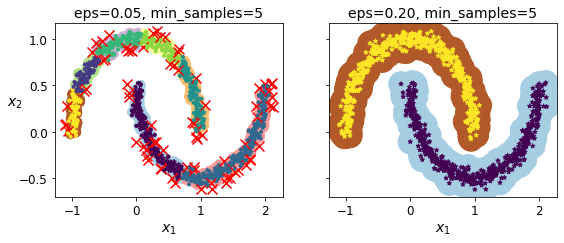

In [181]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()


In [182]:
dbscan = dbscan2

Somewhat surprisingly, the DBSCAN class does not have a predict() method, although it has a fit_predict() method. In other words, it cannot predict which cluster a new instance belongs to. This implementation decision was made because different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use. Moreover, it’s not hard to implement. For example, let’s train a KNeighborsClassifier:

In [183]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now, given a few new instances, we can predict which cluster they most likely belong to and even estimate a probability for each cluster:

In [184]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [185]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Note that we only trained the classifier on the core instances, but we could also have chosen to train it on all the instances, or all but the anomalies: this choice depends on the final task.

The  decision  boundary  is  represented  in  Figure  below  (the  crosses  represent  the  four instances in X_new). Notice that since there is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away. It is fairly straight‐forward  to  introduce  a  maximum  distance,  in  which  case  the  two  instances  that  arefar  away  from  both  clusters  are  classified  as  anomalies.  To  do  this,  use  the  kneighbors() method of the KNeighborsClassifier. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns):

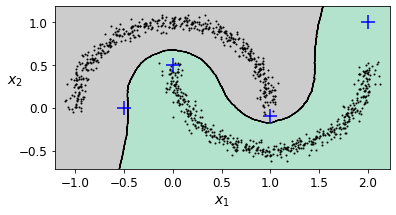

In [186]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)

plt.show()

In [187]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In short, DBSCAN is a very simple yet powerful algorithm capable of identifying any number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters  (eps  and  min_samples).  If  the  density  varies  significantly  across  the  clusters, however,  it  can  be  impossible  for  it  to  capture  all  the  clusters  properly.  Its  computational complexity is roughly O(m log m), making it pretty close to linear with regard to  the  number  of  instances,  but  Scikit-Learn’s  implementation  can  require  up  to O(m<sup>2</sup>) memory if eps is large.

## Other clustering Algorithms

Scikit-Learn  implements  several  more  clustering  algorithms:

- Agglomerative clustering
- BIRCH
- Mean-Shift
- Affinity propagation
- Spectral clustering

We will discuss in short about **Spectral Clustering** and **Agglomerative Clustering**.

#### Spectral Clustering

This algorithm takes a similarity matrix between the instances and creates a low-dimensional  embedding  from  it  (i.e.,  it  reduces  its  dimensionality),  then  it  uses another clustering algorithm in this low-dimensional space (Scikit-Learn’s implementation uses K-Means.) Spectral clustering can capture complex cluster structures, and it can also be used to cut graphs (e.g., to identify clusters of friends on a social network). It does not scale well to large numbers of instances, and it does not behave well when the clusters have very different sizes.

In [188]:
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [189]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

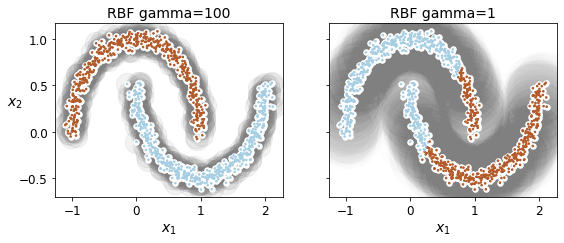

In [190]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


#### Agglomerative Clustering

A hierarchy of clusters is built from the bottom up. Think of many tiny bubbles floating on water and gradually attaching to each other until there’s one big group of  bubbles.  Similarly,  at  each  iteration,  agglomerative  clustering  connects  the nearest  pair  of  clusters  (starting  with  individual  instances).  If  you  drew  a  tree with a branch for every pair of clusters that merged, you would get a binary tree of  clusters,  where  the  leaves  are  the  individual  instances.  This  approach  scales very well to large numbers of instances or clusters. It can capture clusters of various  shapes,  it  produces  a  flexible  and  informative  cluster  tree  instead  of  forcing you to choose a particular cluster scale, and it can be used with any pairwise distance. It can scale nicely to large numbers of instances if you provide a connectivity matrix, which is a sparse m × m matrix that indicates which pairs of instancesare   neighbors (e.g., returned by sklearn.neighbors.kneighbors_graph()). Without a connectivity matrix, the algorithm does not scale well to large datasets.

In [5]:
from sklearn.cluster import AgglomerativeClustering

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [6]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

## Gaussian Mixtures

A  Gaussian  mixture  model  (GMM)  is  a  probabilistic  model  that  assumes  that  the instances  were  generated  from  a  mixture  of  several  Gaussian  distributions  whose parameters  are  unknown.  All  the  instances  generated  from  a  single  Gaussian  distribution form a cluster that typically looks like an ellipsoid. Each cluster can have a different  ellipsoidal  shape,  size,  density,  and  orientation.  When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

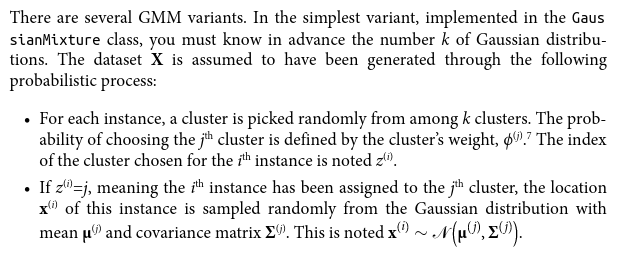

This  generative  process  can  be  represented  as  a  graphical  model.  Figure  below  represents the structure of the conditional dependencies between random variables.

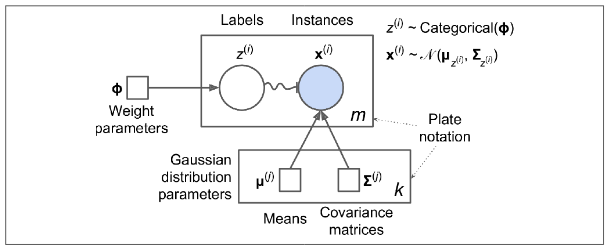

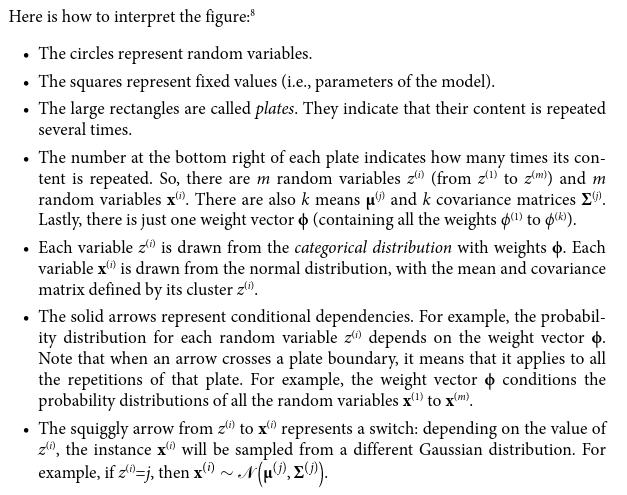
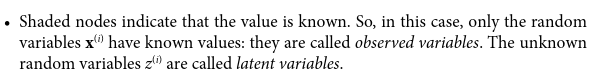

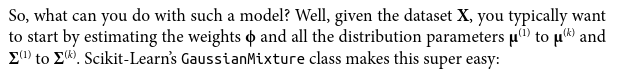

In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [4]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the algorithm estimated:

In [5]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [6]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [7]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

Great,  it  worked  fine!  Indeed,  the  weights  that  were  used  to  generate  the  data  were 0.2, 0.4, and 0.4; and similarly, the means and covariance matrices were very close to those  found  by  the  algorithm.  But  how?  This  class  relies  on  the  Expectation-Maximization  (EM)  algorithm,  which  has  many  similarities  with  the  K-Means  algorithm:  it  also  initializes  the  cluster  parameters  randomly,  then  it  repeats  two  steps until  convergence,  first  assigning  instances  to  clusters  (this  is  called  the  expectation step)  and  then  updating  the  clusters  (this  is  called  the  maximization  step).  Soundsfamiliar, right? In the context of clustering, you can think of EM as a generalization of K-Means that not only finds the cluster centers (μ(1) to μ(k)), but also their size, shape, and  orientation  (Σ(1)  to  Σ(k)),  as  well  as  their  relative  weights  (φ(1)  to  φ(k)). Unlike  K-Means,  though,  EM  uses  soft  cluster  assignments,  not  hard  assignments.  For  each instance,  during  the  expectation  step,  the  algorithm  estimates  the  probability  that  it belongs  to  each  cluster  (based  on  the  current  cluster  parameters).  Then,  during  the maximization step, each cluster is updated using all the instances in the dataset, with each  instance  weighted  by  the  estimated  probability  that  it  belongs  to  that  cluster. These  probabilities  are  called  the  responsibilities  of  the  clusters  for  the  instances. During the maximization step, each cluster's update will mostly be impacted by the instances it is most responsible for.

Unfortunately, just like K-Means, EM can end up converging to poor solutions, so it needs to be run several times, keeping only the best solution. This is why we set n_init to 10, by default n_init is set to 1.

You  can  check  whether  or  not  the  algorithm  converged  and  how  many  iterations  it took:

In [8]:
gm.converged_

True

In [9]:
gm.n_iter_

4

Now  that  you  have  an  estimate  of  the  location,  size,  shape,  orientation,  and  relative weight  of  each  cluster,  the  model  can  easily  assign  each  instance  to  the  most  likely cluster  (hard  clustering)  or  estimate  the  probability  that  it  belongs  to  a  particular cluster  (soft  clustering).  Just  use  the  predict()  method  for  hard  clustering,  or  the predict_proba() method for soft clustering:

In [10]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [11]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

A  Gaussian  mixture  model  is  a  generative  model,  meaning  you  can  sample  new instances from it (note that they are ordered by cluster index):

In [12]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [13]:
y_new

array([0, 0, 1, 2, 2, 2])

It  is  also  possible  to  estimate  the  density  of  the  model  at  any  given  location.  This  is achieved  using  the  score_samples()  method:  for  each  instance  it  is  given,  this method  estimates  the  log  of  the  probability  density  function  (PDF)  at  that  location. The greater the score, the higher the density:

In [14]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

If  you  compute  the  exponential  of  these  scores,  you  get  the  value  of  the  PDF  at  the location  of  the  given  instances.  These  are  not  probabilities,  but  probability densities: they can take on any positive value, not just a value between 0 and 1. To estimate the probability  that  an  instance  will  fall  within  a  particular  region,  you  would  have  to integrate  the  PDF  over  that  region  (if  you  do  so  over  the  entire  space  of  possible instance locations, the result will be 1).

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [15]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [16]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

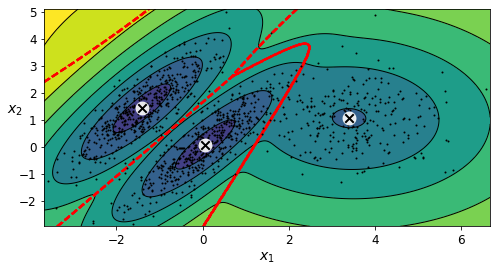

In [17]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

The algorithm clearly found an excellent solution. Of course, we made its task easy  by  generating  the  data  using  a  set  of  2D  Gaussian  distributions  (unfortunately, real-life data is not always so Gaussian and low-dimensional). We also gave the algorithm  the  correct  number  of  clusters.  When  there  are  many  dimensions,  or  many clusters,  or  few  instances,  EM  can  struggle  to  converge  to  the  optimal  solution.  You might need to reduce the difficulty of the task by limiting the number of parameters that the algorithm has to learn. One way to do this is to limit the range of shapes and orientations that the clusters can have. This can be achieved by imposing constraintson  the  covariance  matrices.  To  do  this,  set  the  covariance_type  hyperparameter  to one of the following values:

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

By  default,  covariance_type  is  equal  to  "full",  which  means  that  each  cluster  can take  on  any  shape,  size,  and  orientation  (it  has  its  own  unconstrained  covariance matrix).  Figure  below  plots  the  solutions  found  by  the  EM  algorithm  when  covariance_type is set to "tied" or "spherical.”

In [18]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [19]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


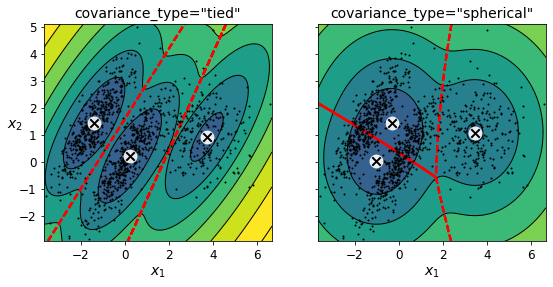

In [20]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

plt.show()

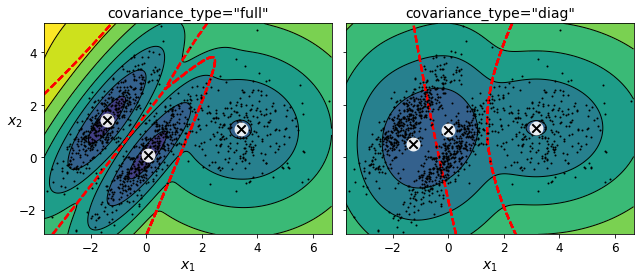

In [21]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

The   computational   complexity   of   training   a   GaussianMixture model  depends  on  the  number  of  instances  m,  the  number  of dimensions n, the number of clusters k, and the constraints on the covariance matrices. If covariance_type is "spherical or "diag", it  is  O(kmn),  assuming  the  data  has  a  clustering  structure.  If  covariance_type is "tied" or "full", it is O(kmn<sup>2</sup> + kn<sup>3</sup>), so it will not scale to large numbers of features.

### Anomaly Detection Using Gaussian Mixtures

Anomaly detection (also called outlier detection) is the task of detecting instances that deviate  strongly  from  the  norm.  These  instances  are  called  anomalies,  or  outliers, while  the  normal  instances  are  called  inliers.  Anomaly  detection  is  useful  in  a  wide variety of applications, such as fraud detection, detecting defective products in manufacturing, or removing outliers from a dataset before training another model (which can significantly improve the performance of the resulting model).

Using a Gaussian mixture model for anomaly detection is quite simple: any instance located in a low-density region can be considered an anomaly. You must define what density  threshold  you  want  to  use.  For  example,  in  a  manufacturing  company  that tries  to  detect  defective  products,  the  ratio  of  defective  products  is  usually  wellknown.  Say  it  is  equal  to  4%.  You  then  set  the  density  threshold  to  be  the  value  that results in having 4% of the instances located in areas below that threshold density. If you notice that you get too many false positives (i.e., perfectly good products that are flagged  as  defective),  you  can  lower  the  threshold.  Conversely,  if  you  have  too  many false negatives (i.e., defective products that the system does not flag as defective), you can increase the threshold. This is the usual precision/recall trade-off. Here is how you would identify the outliers using the fourth percentile lowest densityas the threshold (i.e., approximately 4% of the instances will be flagged as anomalies):

In [22]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

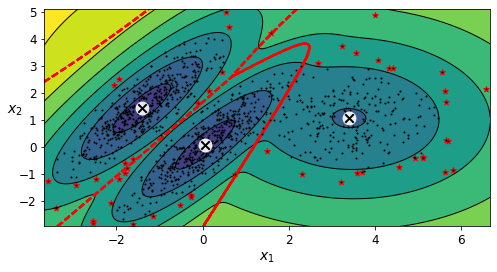

In [24]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

A closely related task is novelty detection: it differs from anomaly detection in that the algorithm is assumed to be trained on a “clean” dataset, uncontaminated by outliers, whereas anomaly detection does not make this assumption. Indeed, outlier detection is often used to clean up a dataset.

Gaussian mixture models try to fit all the data, including the outliers, so if you have too many of them, this will bias the model’s view of  “normality,”  and  some  outliers  may  wrongly  be  considered  as normal. If this happens, you can try to fit the model once, use it to detect  and  remove  the  most  extreme  outliers,  then  fit  the  model again on the cleaned-up dataset. Another approach is to use robust covariance estimation methods (see the EllipticEnvelope class).